# A guide Portfolio Optimization Environment

This notebook aims to provide an example of using PortfolioOptimizationEnv (or POE) to train a reinforcement learning model that learns to solve the portfolio optimization problem.

In this document, we will reproduce a famous architecture called EIIE (ensemble of identical independent evaluators), introduced in the following paper:

- Zhengyao Jiang, Dixing Xu, & Jinjun Liang. (2017). A Deep Reinforcement Learning Framework for the Financial Portfolio Management Problem. https://doi.org/10.48550/arXiv.1706.10059.

It's advisable to read it to understand the algorithm implemented in this notebook.

### Note
If you're using this environment, consider citing the following paper (in adittion to FinRL references):

- Caio Costa, & Anna Costa (2023). POE: A General Portfolio Optimization Environment for FinRL. In *Anais do II Brazilian Workshop on Artificial Intelligence in Finance* (pp. 132–143). SBC. https://doi.org/10.5753/bwaif.2023.231144.

```
@inproceedings{bwaif,
 author = {Caio Costa and Anna Costa},
 title = {POE: A General Portfolio Optimization Environment for FinRL},
 booktitle = {Anais do II Brazilian Workshop on Artificial Intelligence in Finance},
 location = {João Pessoa/PB},
 year = {2023},
 keywords = {},
 issn = {0000-0000},
 pages = {132--143},
 publisher = {SBC},
 address = {Porto Alegre, RS, Brasil},
 doi = {10.5753/bwaif.2023.231144},
 url = {https://sol.sbc.org.br/index.php/bwaif/article/view/24959}
}

```

## Installation and imports

To run this notebook in google colab, uncomment the cells below.

In [1]:
## install finrl library
# !sudo apt install swig
# !pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

In [42]:
## We also need to install quantstats, because the environment uses it to plot graphs
# !pip install quantstats

In [2]:
## Hide matplotlib warnings
# import warnings
# warnings.filterwarnings('ignore')

import logging
logging.getLogger('matplotlib.font_manager').disabled = True

#### Import the necessary code libraries

In [3]:
import torch

import numpy as np

from sklearn.preprocessing import MaxAbsScaler

from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import GroupByScaler
from finrl.meta.env_portfolio_optimization.env_portfolio_optimization import PortfolioOptimizationEnv
from finrl.agents.portfolio_optimization.models import DRLAgent
from finrl.agents.portfolio_optimization.architectures import EIIE

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [4]:
print(device)

cuda:0


## Fetch data

In his paper, *Jiang et al* creates a portfolio composed by the top-11 cryptocurrencies based on 30-days volume. Since it's not specified when this classification was done, it's difficult to reproduce, so we will use a similar approach in the Brazillian stock market:

- We select top-10 stocks from Brazillian stock market;
- For simplicity, we disconsider stocks that have missing data for the days in period 2011-01-01 to 2019-12-31 (9 years);

In [9]:
TOP_BRL = [
    "VALE3.SA", "PETR4.SA", "ITUB4.SA", "BBDC4.SA",
    "BBAS3.SA", "RENT3.SA", "LREN3.SA", "PRIO3.SA",
    "WEGE3.SA", "ABEV3.SA"
]

In [10]:
print(len(TOP_DAX))

portfolio_raw_df = YahooDownloader(start_date = '2010-01-01',
                                end_date = '2023-12-31',
                                ticker_list = TOP_BRL).fetch_data()
portfolio_raw_df

[*********************100%%**********************]  1 of 1 completed

7



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Shape of DataFrame:  (34529, 8)


,date,open,high,low,close,volume,tic,day
0,2010-01-04,5.932941,6.121129,5.873407,3.638693,818417,ABEV3.SA,0
1,2010-01-04,14.900000,15.000000,14.850000,6.009223,7249400,BBAS3.SA,0
2,2010-01-04,13.077717,13.460998,13.059972,7.395346,10148480,BBDC4.SA,0
3,2010-01-04,17.708261,18.436810,17.708261,10.135934,11843397,ITUB4.SA,0
4,2010-01-04,5.962969,6.010673,5.848182,4.309988,6352539,LREN3.SA,0
...,...,...,...,...,...,...,...,...
34524,2023-12-28,37.230000,37.360001,37.040001,34.717762,21421900,PETR4.SA,3
34525,2023-12-28,45.820000,46.049999,45.320000,46.049999,7871200,PRIO3.SA,3
34526,2023-12-28,63.450001,63.900002,63.209999,63.136684,3404700,RENT3.SA,3
34527,2023-12-28,77.000000,77.459999,76.750000,73.894554,16545800,VALE3.SA,3


In [7]:
portfolio_raw_df.groupby("tic").count()

,date,open,high,low,close,volume,day
tic,,,,,,,
ADS.DE,3557,3557,3557,3557,3557,3557,3557
AIR.PA,3583,3583,3583,3583,3583,3583,3583
ALV.DE,3557,3557,3557,3557,3557,3557,3557
DTE.DE,3557,3557,3557,3557,3557,3557,3557
IFX.DE,3557,3557,3557,3557,3557,3557,3557
SAP.DE,3557,3557,3557,3557,3557,3557,3557
SIE.DE,3557,3557,3557,3557,3557,3557,3557


### Normalize Data

We normalize the data dividing the time series of each stock by its maximum value, so that the dataframe contains values between 0 and 1.

In [9]:
portfolio_norm_df = GroupByScaler(by="tic", scaler=MaxAbsScaler).fit_transform(portfolio_raw_df)
portfolio_norm_df

c:\Users\versu\anaconda3\envs\Thesis\lib\site-packages\finrl\meta\preprocessor\preprocessors.py:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.00200262 0.00114137 0.0010422  ... 0.04565734 0.05214546 0.07760399]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.loc[select_mask, self.columns] = self.scalers[value].transform(
c:\Users\versu\anaconda3\envs\Thesis\lib\site-packages\finrl\meta\preprocessor\preprocessors.py:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.   0.25 0.5  ... 0.25 0.5  0.75]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  X.loc[select_mask, self.columns] = self.scalers[value].transform(


,date,open,high,low,close,volume,tic,day
0,2011-01-03,0.353928,0.355383,0.359147,0.272027,0.002003,ABEV3.SA,0.00
1,2011-01-03,0.566547,0.568771,0.572419,0.327830,0.014581,BBAS3.SA,0.00
2,2011-01-03,0.396939,0.397479,0.399922,0.287841,0.021760,BBDC4.SA,0.00
3,2011-01-03,0.466293,0.458661,0.467793,0.322621,0.062331,ITUB4.SA,0.00
4,2011-01-03,0.153498,0.157120,0.155466,0.127001,0.072591,LREN3.SA,0.00
...,...,...,...,...,...,...,...,...
29775,2022-12-29,0.663745,0.652514,0.662958,0.694899,0.082841,PETR4.SA,0.75
29776,2022-12-29,0.858295,0.844144,0.878173,0.857373,0.048724,PRIO3.SA,0.75
29777,2022-12-29,0.737949,0.754746,0.727218,0.728887,0.097191,RENT3.SA,0.75
29778,2022-12-29,0.742905,0.746783,0.770759,0.916710,0.218546,VALE3.SA,0.75


In [10]:
df_portfolio = portfolio_norm_df[["date", "tic", "close", "high", "low"]]

df_portfolio_train = df_portfolio[(df_portfolio["date"] >= "2011-01-01") & (df_portfolio["date"] < "2019-12-31")]
df_portfolio_2020 = df_portfolio[(df_portfolio["date"] >= "2020-01-01") & (df_portfolio["date"] < "2020-12-31")]
df_portfolio_2021 = df_portfolio[(df_portfolio["date"] >= "2021-01-01") & (df_portfolio["date"] < "2021-12-31")]
df_portfolio_2022 = df_portfolio[(df_portfolio["date"] >= "2022-01-01") & (df_portfolio["date"] < "2022-12-31")]

### Instantiate Environment

Using the `PortfolioOptimizationEnv`, it's easy to instantiate a portfolio optimization environment for reinforcement learning agents. In the example below, we use the dataframe created before to start an environment.

In [11]:
environment = PortfolioOptimizationEnv(
        df_portfolio_train,
        initial_amount=100000,
        comission_fee_pct=0.0025,
        time_window=50,
        features=["close", "high", "low"],
        normalize_df=None
    )

### Instantiate Model

Now, we can instantiate the model using FinRL API. In this example, we are going to use the EIIE architecture introduced by Jiang et. al.

:exclamation: **Note:** Remember to set the architecture's `time_window` parameter with the same value of the environment's `time_window`.

In [13]:
# set PolicyGradient parameters
model_kwargs = {
    "lr": 0.01,
    "policy": EIIE,
}

# here, we can set EIIE's parameters
policy_kwargs = {
    "k_size": 3,
    "time_window": 50,
}

model = DRLAgent(environment).get_model("pg", device, model_kwargs, policy_kwargs)

### Train Model

In [16]:
DRLAgent.train_model(model, episodes=40)

  0%|          | 0/40 [00:00<?, ?it/s]

Initial portfolio value:100000
Final portfolio value: 499986.90625
Final accumulative portfolio value: 4.9998690625
Maximum DrawDown: -0.45405732267483245
Sharpe ratio: 0.968019288413352


  2%|▎         | 1/40 [00:34<22:40, 34.89s/it]

Initial portfolio value:100000
Final portfolio value: 893705.375
Final accumulative portfolio value: 8.93705375
Maximum DrawDown: -0.5388640623991531
Sharpe ratio: 1.06022183337969


  5%|▌         | 2/40 [01:08<21:48, 34.43s/it]

Initial portfolio value:100000
Final portfolio value: 866009.875
Final accumulative portfolio value: 8.66009875
Maximum DrawDown: -0.62821579830475
Sharpe ratio: 0.9921228617487011


  8%|▊         | 3/40 [01:42<21:00, 34.06s/it]

Initial portfolio value:100000
Final portfolio value: 1215823.5
Final accumulative portfolio value: 12.158235
Maximum DrawDown: -0.6314125165072452
Sharpe ratio: 1.024295329709386


 10%|█         | 4/40 [02:17<20:35, 34.32s/it]

Initial portfolio value:100000
Final portfolio value: 1021122.1875
Final accumulative portfolio value: 10.211221875
Maximum DrawDown: -0.7198797673265622
Sharpe ratio: 0.8989781533115405


 12%|█▎        | 5/40 [02:52<20:10, 34.58s/it]

Initial portfolio value:100000
Final portfolio value: 1323487.5
Final accumulative portfolio value: 13.234875
Maximum DrawDown: -0.6733457283591129
Sharpe ratio: 0.9953010736438175


 15%|█▌        | 6/40 [03:28<19:48, 34.95s/it]

Initial portfolio value:100000
Final portfolio value: 1277014.875
Final accumulative portfolio value: 12.77014875
Maximum DrawDown: -0.7333770018298043
Sharpe ratio: 0.9249360369072666


 18%|█▊        | 7/40 [04:02<19:03, 34.66s/it]

Initial portfolio value:100000
Final portfolio value: 1340930.375
Final accumulative portfolio value: 13.40930375
Maximum DrawDown: -0.7070085996245454
Sharpe ratio: 0.9594036251424352


 20%|██        | 8/40 [04:37<18:35, 34.87s/it]

Initial portfolio value:100000
Final portfolio value: 1364750.5
Final accumulative portfolio value: 13.647505
Maximum DrawDown: -0.7090646561245879
Sharpe ratio: 0.95537587540895


 22%|██▎       | 9/40 [05:12<18:00, 34.84s/it]

Initial portfolio value:100000
Final portfolio value: 1423266.625
Final accumulative portfolio value: 14.23266625
Maximum DrawDown: -0.7057782031563593
Sharpe ratio: 0.9654835412408942


 25%|██▌       | 10/40 [05:46<17:22, 34.74s/it]

Initial portfolio value:100000
Final portfolio value: 1460221.0
Final accumulative portfolio value: 14.60221
Maximum DrawDown: -0.6990299356410492
Sharpe ratio: 0.9758282680674485


 28%|██▊       | 11/40 [06:19<16:31, 34.18s/it]

Initial portfolio value:100000
Final portfolio value: 1500718.25
Final accumulative portfolio value: 15.0071825
Maximum DrawDown: -0.6873346002300973
Sharpe ratio: 0.988340617117058


 30%|███       | 12/40 [06:52<15:45, 33.76s/it]

Initial portfolio value:100000
Final portfolio value: 1553952.625
Final accumulative portfolio value: 15.53952625
Maximum DrawDown: -0.6751641616077251
Sharpe ratio: 1.0004137846759922


 32%|███▎      | 13/40 [07:26<15:10, 33.71s/it]

Initial portfolio value:100000
Final portfolio value: 1598804.625
Final accumulative portfolio value: 15.98804625
Maximum DrawDown: -0.662116353285214
Sharpe ratio: 1.0097562645734013


 35%|███▌      | 14/40 [07:59<14:32, 33.54s/it]

Initial portfolio value:100000
Final portfolio value: 1696146.625
Final accumulative portfolio value: 16.96146625
Maximum DrawDown: -0.645860052965934
Sharpe ratio: 1.028734967034347


 38%|███▊      | 15/40 [08:31<13:52, 33.31s/it]

Initial portfolio value:100000
Final portfolio value: 1792337.75
Final accumulative portfolio value: 17.9233775
Maximum DrawDown: -0.6210563560590707
Sharpe ratio: 1.0499513354240393


 40%|████      | 16/40 [09:06<13:25, 33.55s/it]

Initial portfolio value:100000
Final portfolio value: 1925274.625
Final accumulative portfolio value: 19.25274625
Maximum DrawDown: -0.6090010932646681
Sharpe ratio: 1.0724156832922633


 42%|████▎     | 17/40 [09:41<13:05, 34.14s/it]

Initial portfolio value:100000
Final portfolio value: 2071994.5
Final accumulative portfolio value: 20.719945
Maximum DrawDown: -0.5995843077025991
Sharpe ratio: 1.0920893299091492


 45%|████▌     | 18/40 [10:16<12:34, 34.31s/it]

Initial portfolio value:100000
Final portfolio value: 2265301.0
Final accumulative portfolio value: 22.65301
Maximum DrawDown: -0.5739266782395374
Sharpe ratio: 1.1221798835744585


 48%|████▊     | 19/40 [10:50<11:58, 34.20s/it]

Initial portfolio value:100000
Final portfolio value: 2520982.75
Final accumulative portfolio value: 25.2098275
Maximum DrawDown: -0.5599066166373683
Sharpe ratio: 1.1466845675275343


 50%|█████     | 20/40 [11:23<11:17, 33.88s/it]

Initial portfolio value:100000
Final portfolio value: 2108692.25
Final accumulative portfolio value: 21.0869225
Maximum DrawDown: -0.5975861130052452
Sharpe ratio: 1.0899820046073316


 52%|█████▎    | 21/40 [11:56<10:40, 33.73s/it]

Initial portfolio value:100000
Final portfolio value: 2522765.25
Final accumulative portfolio value: 25.2276525
Maximum DrawDown: -0.6267357260011864
Sharpe ratio: 1.09668040328106


 55%|█████▌    | 22/40 [12:31<10:11, 33.95s/it]

Initial portfolio value:100000
Final portfolio value: 3578885.0
Final accumulative portfolio value: 35.78885
Maximum DrawDown: -0.4853698281477624
Sharpe ratio: 1.2365446100298776


 57%|█████▊    | 23/40 [13:05<09:38, 34.05s/it]

Initial portfolio value:100000
Final portfolio value: 4846298.0
Final accumulative portfolio value: 48.46298
Maximum DrawDown: -0.4934531964391643
Sharpe ratio: 1.3324299232201966


 60%|██████    | 24/40 [13:40<09:07, 34.22s/it]

Initial portfolio value:100000
Final portfolio value: 6365988.0
Final accumulative portfolio value: 63.65988
Maximum DrawDown: -0.49797087088293457
Sharpe ratio: 1.4122422874253109


 62%|██████▎   | 25/40 [14:15<08:39, 34.61s/it]

Initial portfolio value:100000
Final portfolio value: 7501626.5
Final accumulative portfolio value: 75.016265
Maximum DrawDown: -0.4997746228335809
Sharpe ratio: 1.4467995399676277


 65%|██████▌   | 26/40 [14:52<08:13, 35.22s/it]

Initial portfolio value:100000
Final portfolio value: 7863217.0
Final accumulative portfolio value: 78.63217
Maximum DrawDown: -0.49948894036210933
Sharpe ratio: 1.4628232368995966


 68%|██████▊   | 27/40 [15:25<07:28, 34.53s/it]

Initial portfolio value:100000
Final portfolio value: 7957345.5
Final accumulative portfolio value: 79.573455
Maximum DrawDown: -0.50020172672373
Sharpe ratio: 1.4664249838026908


 70%|███████   | 28/40 [15:58<06:50, 34.24s/it]

Initial portfolio value:100000
Final portfolio value: 8893613.0
Final accumulative portfolio value: 88.93613
Maximum DrawDown: -0.500900949200683
Sharpe ratio: 1.4796206067284379


 72%|███████▎  | 29/40 [16:32<06:13, 33.96s/it]

Initial portfolio value:100000
Final portfolio value: 8686828.0
Final accumulative portfolio value: 86.86828
Maximum DrawDown: -0.5007905774282081
Sharpe ratio: 1.473045568700599


 75%|███████▌  | 30/40 [17:04<05:35, 33.58s/it]

Initial portfolio value:100000
Final portfolio value: 9891866.0
Final accumulative portfolio value: 98.91866
Maximum DrawDown: -0.5013766567335509
Sharpe ratio: 1.4940257484611643


 78%|███████▊  | 31/40 [17:37<04:59, 33.31s/it]

Initial portfolio value:100000
Final portfolio value: 8897810.0
Final accumulative portfolio value: 88.9781
Maximum DrawDown: -0.5008900690140219
Sharpe ratio: 1.4749573484059089


 80%|████████  | 32/40 [18:10<04:25, 33.14s/it]

Initial portfolio value:100000
Final portfolio value: 11615530.0
Final accumulative portfolio value: 116.1553
Maximum DrawDown: -0.5017603948741811
Sharpe ratio: 1.5210157153035058


 82%|████████▎ | 33/40 [18:42<03:50, 33.00s/it]

Initial portfolio value:100000
Final portfolio value: 9385434.0
Final accumulative portfolio value: 93.85434
Maximum DrawDown: -0.5001301735676371
Sharpe ratio: 1.4766502330308806


 85%|████████▌ | 34/40 [19:15<03:17, 32.91s/it]

Initial portfolio value:100000
Final portfolio value: 11282023.0
Final accumulative portfolio value: 112.82023
Maximum DrawDown: -0.5016871771383681
Sharpe ratio: 1.5106818163546505


 88%|████████▊ | 35/40 [19:48<02:44, 32.86s/it]

Initial portfolio value:100000
Final portfolio value: 9667203.0
Final accumulative portfolio value: 96.67203
Maximum DrawDown: -0.5005087228263445
Sharpe ratio: 1.4799278853414353


 90%|█████████ | 36/40 [20:21<02:11, 32.84s/it]

Initial portfolio value:100000
Final portfolio value: 13679865.0
Final accumulative portfolio value: 136.79865
Maximum DrawDown: -0.5018311006956965
Sharpe ratio: 1.5458995913080598


 92%|█████████▎| 37/40 [20:54<01:38, 32.95s/it]

Initial portfolio value:100000
Final portfolio value: 10235322.0
Final accumulative portfolio value: 102.35322
Maximum DrawDown: -0.5020485674909728
Sharpe ratio: 1.44585599148432


 95%|█████████▌| 38/40 [21:27<01:05, 32.96s/it]

Initial portfolio value:100000
Final portfolio value: 2024597.375
Final accumulative portfolio value: 20.24597375
Maximum DrawDown: -0.8264512824786289
Sharpe ratio: 0.9171963032740433


 98%|█████████▊| 39/40 [22:00<00:32, 32.98s/it]

Initial portfolio value:100000
Final portfolio value: 6099631.0
Final accumulative portfolio value: 60.99631
Maximum DrawDown: -0.5130838620448455
Sharpe ratio: 1.2536157439881692


100%|██████████| 40/40 [22:33<00:00, 33.83s/it]


### Save Model

In [17]:
torch.save(model.train_policy.state_dict(), "policy_EIIE.pt")

## Test Model

### Instantiate different environments

Since we have three different periods of time, we need three different environments instantiated to simulate them.

In [18]:
environment_2020 = PortfolioOptimizationEnv(
    df_portfolio_2020,
    initial_amount=100000,
    comission_fee_pct=0.0025,
    time_window=50,
    features=["close", "high", "low"],
    normalize_df=None
)

environment_2021 = PortfolioOptimizationEnv(
    df_portfolio_2021,
    initial_amount=100000,
    comission_fee_pct=0.0025,
    time_window=50,
    features=["close", "high", "low"],
    normalize_df=None
)

environment_2022 = PortfolioOptimizationEnv(
    df_portfolio_2022,
    initial_amount=100000,
    comission_fee_pct=0.0025,
    time_window=50,
    features=["close", "high", "low"],
    normalize_df=None
)

### Test EIIE architecture
Now, we can test the EIIE architecture in the three different test periods. It's important no note that, in this code, we load the saved policy even though it's not necessary just to show how to save and load your model.

In [19]:
EIIE_results = {
    "training": environment._asset_memory["final"],
    "2020": {},
    "2021": {},
    "2022": {}
}

# instantiate an architecture with the same arguments used in training
# and load with load_state_dict.
policy = EIIE(time_window=50, device=device)
policy.load_state_dict(torch.load("policy_EIIE.pt"))

# 2020
DRLAgent.DRL_validation(model, environment_2020, policy=policy)
EIIE_results["2020"]["value"] = environment_2020._asset_memory["final"]

# 2021
DRLAgent.DRL_validation(model, environment_2021, policy=policy)
EIIE_results["2021"]["value"] = environment_2021._asset_memory["final"]

# 2022
DRLAgent.DRL_validation(model, environment_2022, policy=policy)
EIIE_results["2022"]["value"] = environment_2022._asset_memory["final"]

Initial portfolio value:100000
Final portfolio value: 390768.5625
Final accumulative portfolio value: 3.907685625
Maximum DrawDown: -0.3372631953008506
Sharpe ratio: 2.511236417562906
Initial portfolio value:100000
Final portfolio value: 100000.0
Final accumulative portfolio value: 1.0
Maximum DrawDown: 0.0
Sharpe ratio: nan


c:\Users\versu\anaconda3\envs\Thesis\lib\site-packages\quantstats\stats.py:294: RuntimeWarning: invalid value encountered in scalar divide
  res = returns.mean() / divisor


Initial portfolio value:100000
Final portfolio value: 100000.0
Final accumulative portfolio value: 1.0
Maximum DrawDown: 0.0
Sharpe ratio: nan


c:\Users\versu\anaconda3\envs\Thesis\lib\site-packages\quantstats\stats.py:294: RuntimeWarning: invalid value encountered in scalar divide
  res = returns.mean() / divisor


### Test Uniform Buy and Hold
For comparison, we will also test the performance of a uniform buy and hold strategy. In this strategy, the portfolio has no remaining cash and the same percentage of money is allocated in each asset.

In [20]:
UBAH_results = {
    "train": {},
    "2020": {},
    "2021": {},
    "2022": {}
}

PORTFOLIO_SIZE = len(TOP_BRL)

# train period
terminated = False
environment.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment.step(action)
UBAH_results["train"]["value"] = environment._asset_memory["final"]

# 2020
terminated = False
environment_2020.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment_2020.step(action)
UBAH_results["2020"]["value"] = environment_2020._asset_memory["final"]

# 2021
terminated = False
environment_2021.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment_2021.step(action)
UBAH_results["2021"]["value"] = environment_2021._asset_memory["final"]

# 2022
terminated = False
environment_2022.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment_2022.step(action)
UBAH_results["2022"]["value"] = environment_2022._asset_memory["final"]

Initial portfolio value:100000
Final portfolio value: 398356.8125
Final accumulative portfolio value: 3.983568125
Maximum DrawDown: -0.47863780787101495
Sharpe ratio: 0.7799057223003308
Initial portfolio value:100000
Final portfolio value: 170950.59375
Final accumulative portfolio value: 1.7095059375
Maximum DrawDown: -0.25078875
Sharpe ratio: 1.709812042377107
Initial portfolio value:100000
Final portfolio value: 95715.8046875
Final accumulative portfolio value: 0.957158046875
Maximum DrawDown: -0.17292892342818966
Sharpe ratio: -0.15637314000471042
Initial portfolio value:100000
Final portfolio value: 113415.1015625
Final accumulative portfolio value: 1.134151015625
Maximum DrawDown: -0.16770396065239324
Sharpe ratio: 0.8079285651353826


### Plot graphics

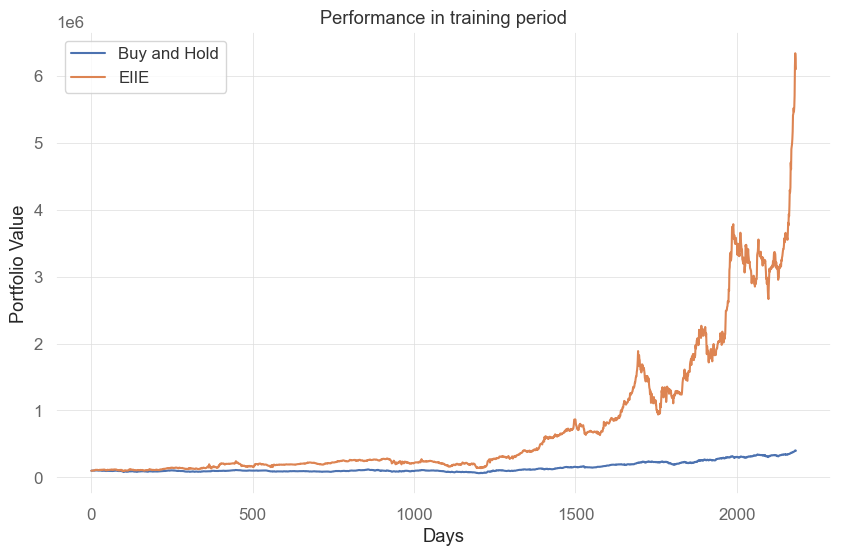

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.plot(UBAH_results["train"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["training"], label="EIIE")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in training period")
plt.legend()

plt.show()

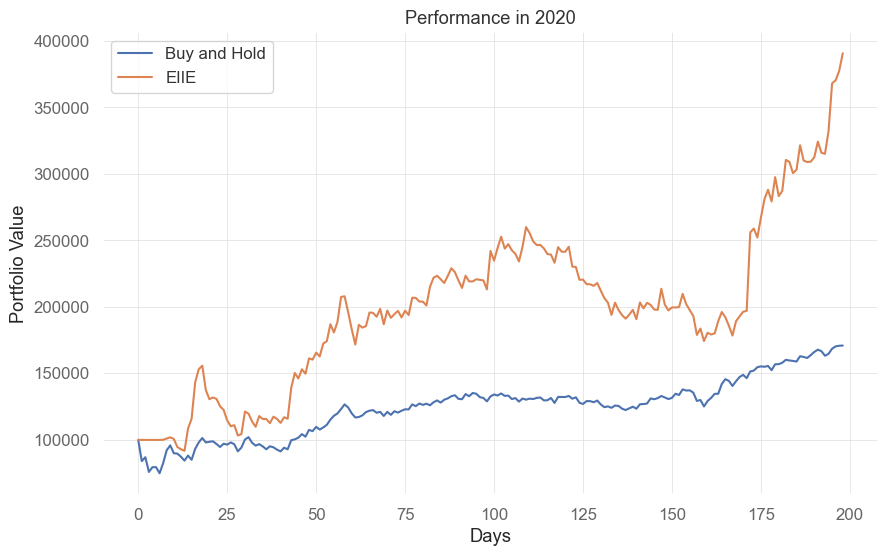

In [22]:
plt.plot(UBAH_results["2020"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["2020"]["value"], label="EIIE")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in 2020")
plt.legend()

plt.show()

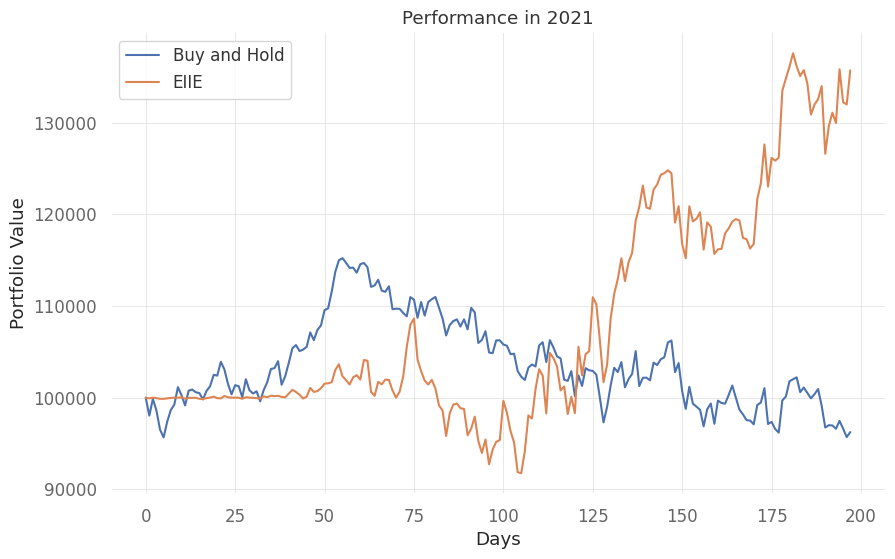

In [59]:
plt.plot(UBAH_results["2021"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["2021"]["value"], label="EIIE")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in 2021")
plt.legend()

plt.show()

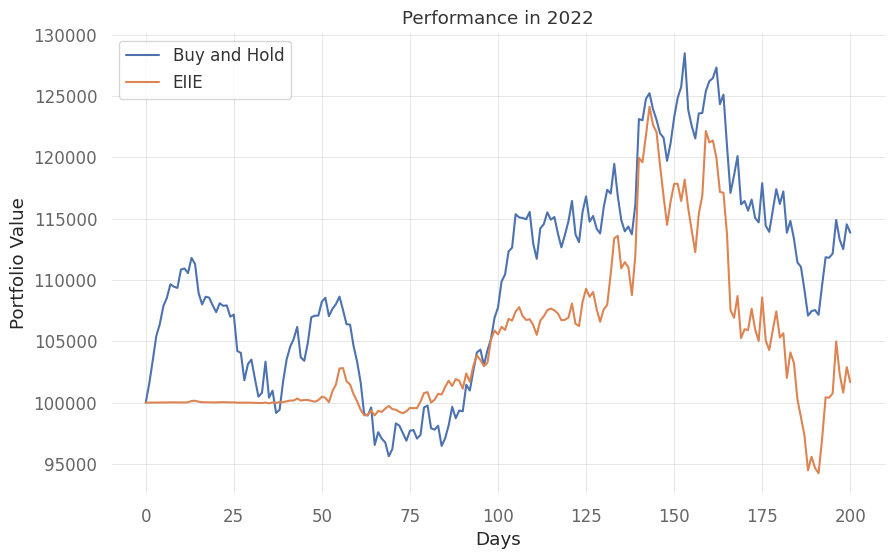

In [60]:
plt.plot(UBAH_results["2022"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["2022"]["value"], label="EIIE")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in 2022")
plt.legend()

plt.show()

We can see that the agent is able to learn a good policy but its performance is worse the more the test period advances into the future. To get a better performance in 2022, for example, the agent should probably be trained again using more recent data.